<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания, занимающаяся такси, собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit  
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor


import warnings
warnings.filterwarnings("ignore")


In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=['datetime'], parse_dates=[0])

In [3]:
data.sort_index(inplace=True)

In [4]:
data = data.resample('1H').sum()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
data.index.is_monotonic

True

In [8]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
num_orders,0.000000


In [9]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


<AxesSubplot:xlabel='datetime'>

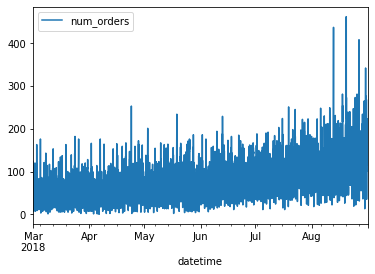

In [10]:
data.plot()

Вывод: открыли данные, индексом поставили данные о времени и дате, сделали ресемплирование по одному часу, проверили расположение в хронологическом порядке, пропуски, какие данные есть, вывели график.

## Анализ

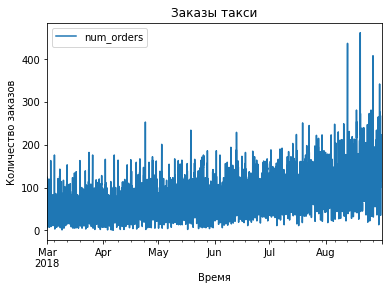

In [11]:
data.plot()
plt.title('Заказы такси')
plt.ylabel('Количество заказов')
plt.xlabel('Время')
plt.show()

Вывод: по данному графику не очень что-то понятно

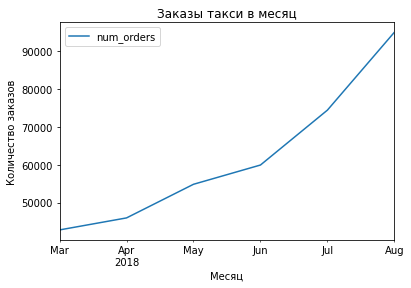

In [12]:
resample_month = data.resample('1M').sum()
resample_month.plot()
plt.title('Заказы такси в месяц')
plt.ylabel('Количество заказов')
plt.xlabel('Месяц')
plt.show()

Вывод: заказы такси по количеству увеличились летом

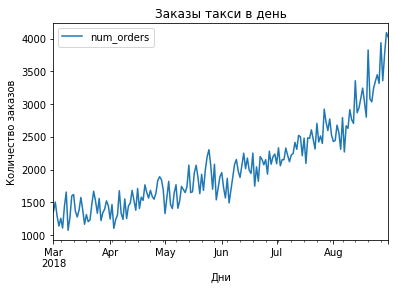

In [13]:
resample_day = data.resample('1D').sum()
resample_day.plot()
plt.title('Заказы такси в день')
plt.ylabel('Количество заказов')
plt.xlabel('Дни')
plt.show()

Вывод: по дням неоднородная картина, постоянные колебания

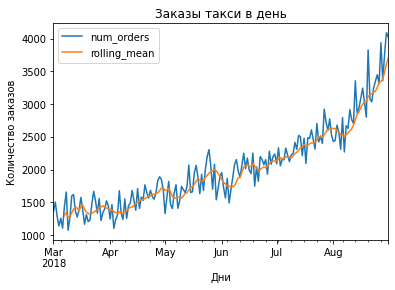

In [14]:
resample_day['rolling_mean'] = resample_day.rolling(7).mean()
resample_day.plot()
plt.title('Заказы такси в день')
plt.ylabel('Количество заказов')
plt.xlabel('Дни')
plt.show()

Вывод: посмотрели на скользящее среднее, ряд нестационарный, так как меняется среднее и стандартное отклонение

Посмотрим тренды и сезонность

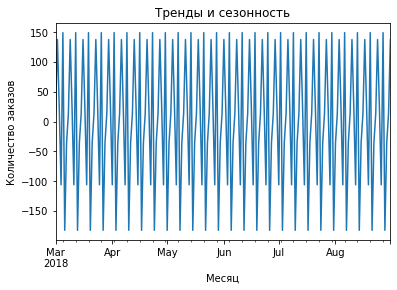

In [15]:
decomposed = seasonal_decompose(resample_day['num_orders'])
decomposed.seasonal.plot()
plt.title('Тренды и сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Месяц')
plt.show()


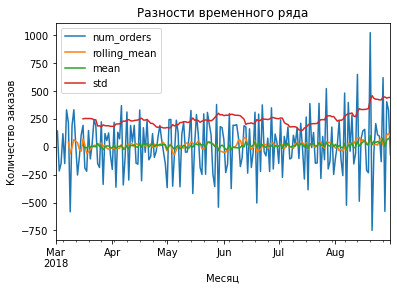

In [16]:
resample_day = resample_day - resample_day.shift()
resample_day['mean'] = resample_day['num_orders'].rolling(15).mean()
resample_day['std'] = resample_day['num_orders'].rolling(15).std()
resample_day.plot()
plt.title('Разности временного ряда')
plt.ylabel('Количество заказов')
plt.xlabel('Месяц')
plt.show()

Вывод: нашли разности временного ряда, так рядом более стационарный при вычитании разности

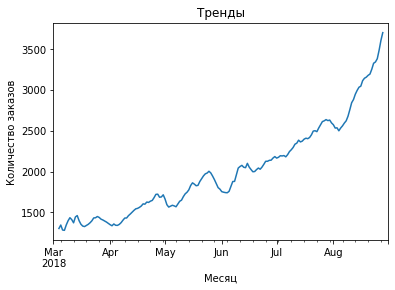

In [17]:
decomposed.trend.plot()
plt.title('Тренды')
plt.ylabel('Количество заказов')
plt.xlabel('Месяц')
plt.show()

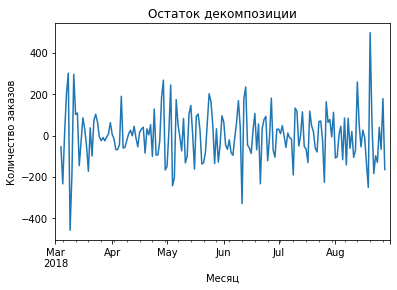

In [18]:
decomposed.resid.plot()
plt.title('Остаток декомпозиции')
plt.ylabel('Количество заказов')
plt.xlabel('Месяц')
plt.show()

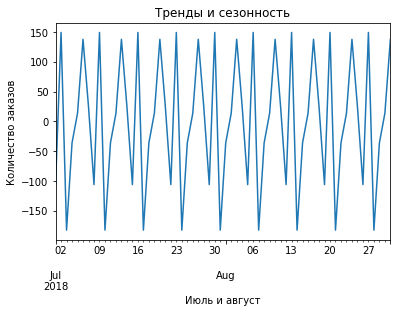

In [19]:
decomposed.seasonal['2018-07-01':'2018-08-31'].plot()
plt.title('Тренды и сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Июль и август')
plt.show()

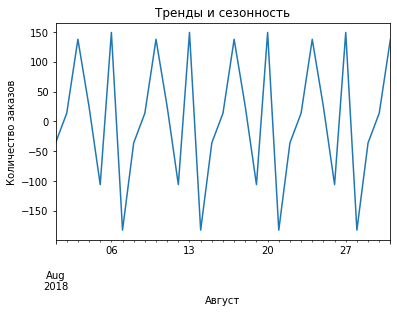

In [20]:
decomposed.seasonal['2018-08-01':'2018-08-31'].plot()
plt.title('Тренды и сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Август')
plt.show()

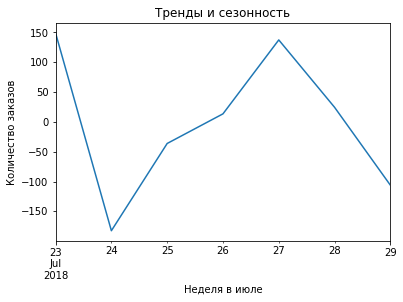

In [21]:
decomposed.seasonal['2018-07-23':'2018-07-29'].plot()
plt.title('Тренды и сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Неделя в июле')
plt.show()

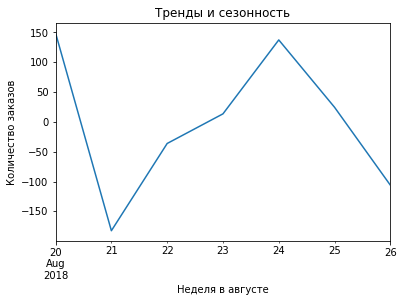

In [22]:
decomposed.seasonal['2018-08-20':'2018-08-26'].plot()
plt.title('Тренды и сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Неделя в августе')
plt.show()

Взяла разные промежутки времени, два месяца, один месяц, разные недели в июле и в августе, можно увидеть, что количество заказов увеличивается к пятнице, а минимальное количество во вторник.

Вывод: графически посмотрели на данные и проанализировали их

## Обучение

In [23]:
def make_features(data, max_lag, rolling_mean_size):
    data_with_features = data.copy()
    data_with_features['year'] = data_with_features.index.year
    data_with_features['month'] = data_with_features.index.month
    data_with_features['day'] = data_with_features.index.day
    data_with_features['dayofweek'] = data_with_features.index.dayofweek
    
    for lag in range(1, max_lag +1):
        data_with_features['lag_{}'.format(lag)] = data_with_features['num_orders'].shift(lag)
    
    data_with_features['rolling_mean'] = data_with_features['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_with_features


In [24]:
data_with_features = make_features(data, 24, 24)

In [25]:
data_with_features.head(5)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
train, test = train_test_split(data_with_features, test_size=0.1, shuffle=False)
train = train.dropna()

In [27]:
train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2018-03-02 00:00:00', freq='H'),
 Timestamp('2018-08-13 13:00:00', freq='H'),
 Timestamp('2018-08-13 14:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

In [28]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [29]:
def parameters_model(features, target, model, param_grid):
    gr = model(random_state=12345)
    tscv = TimeSeriesSplit(n_splits=3)
    grid = GridSearchCV(gr, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv)
    grid = grid.fit(features, target)
    
    rmse = -grid.best_score_
    return rmse**0.5

In [30]:
forest_rmse = parameters_model(features_train, target_train, RandomForestRegressor,  param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
              'max_depth': range (1,13, 2), 'n_estimators': range (10, 51, 10)})

forest_rmse

28.180489672301476

In [31]:
cat_rmse = parameters_model(features_train, target_train, CatBoostRegressor, param_grid={'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [30, 50, 100]
              })
cat_rmse

0:	learn: 29.1841617	total: 50.9ms	remaining: 1.48s
1:	learn: 29.0715481	total: 54.5ms	remaining: 763ms
2:	learn: 28.9342786	total: 58ms	remaining: 522ms
3:	learn: 28.8034692	total: 61.3ms	remaining: 399ms
4:	learn: 28.6822214	total: 64.4ms	remaining: 322ms
5:	learn: 28.5712871	total: 68.3ms	remaining: 273ms
6:	learn: 28.4438609	total: 71.5ms	remaining: 235ms
7:	learn: 28.3235924	total: 74.7ms	remaining: 205ms
8:	learn: 28.1978931	total: 77.8ms	remaining: 181ms
9:	learn: 28.0842310	total: 80.8ms	remaining: 162ms
10:	learn: 27.9774218	total: 83.9ms	remaining: 145ms
11:	learn: 27.8602891	total: 87.1ms	remaining: 131ms
12:	learn: 27.7496078	total: 90.2ms	remaining: 118ms
13:	learn: 27.6448068	total: 93.3ms	remaining: 107ms
14:	learn: 27.5254552	total: 96.4ms	remaining: 96.4ms
15:	learn: 27.4229640	total: 99.4ms	remaining: 87ms
16:	learn: 27.3132927	total: 102ms	remaining: 78.3ms
17:	learn: 27.2010985	total: 106ms	remaining: 70.7ms
18:	learn: 27.1033338	total: 109ms	remaining: 63.2ms
19:	l

27.446955006057912

In [32]:
model=LinearRegression()
tscv = TimeSeriesSplit(n_splits=3)
linear_rmse = (-(cross_val_score(model, features_train, target_train, scoring='neg_mean_squared_error', cv=tscv)).mean())**0.5
linear_rmse

27.699659901292502

In [33]:
comparison = {'model':['forest','catboost', 'linear'], 
              'rmse':['28.18', '27.44', '27.69'] 
              }

df = pd.DataFrame(comparison)
df

,model,rmse
0,forest,28.18
1,catboost,27.44
2,linear,27.69


Вывод: разделили данные на выборки, создали признаки, обучили модели, с помощью перебора параметров и кросс-валидации нашли лучшие показатели. Лучшей моделью выбираю Catboost.

## Тестирование

In [34]:
model_cat_test = CatBoostRegressor()
model_cat_test.fit(features_train, target_train)
predictions_cat_test = model_cat_test.predict(features_test)
rmse_test = (mean_squared_error(target_test, predictions_cat_test))**0.5
rmse_test

Learning rate set to 0.050868
0:	learn: 37.7870445	total: 5.52ms	remaining: 5.51s
1:	learn: 36.9548349	total: 10.6ms	remaining: 5.31s
2:	learn: 36.1947199	total: 15.3ms	remaining: 5.09s
3:	learn: 35.4721438	total: 20ms	remaining: 4.99s
4:	learn: 34.8171642	total: 24.7ms	remaining: 4.92s
5:	learn: 34.1948831	total: 29.6ms	remaining: 4.9s
6:	learn: 33.6085632	total: 34.3ms	remaining: 4.86s
7:	learn: 33.0079126	total: 39ms	remaining: 4.83s
8:	learn: 32.5271741	total: 43.9ms	remaining: 4.83s
9:	learn: 32.0151931	total: 48.7ms	remaining: 4.82s
10:	learn: 31.5180589	total: 53.7ms	remaining: 4.83s
11:	learn: 31.0597174	total: 58.5ms	remaining: 4.81s
12:	learn: 30.6254213	total: 63.5ms	remaining: 4.82s
13:	learn: 30.2920924	total: 68.7ms	remaining: 4.84s
14:	learn: 29.9425264	total: 73.8ms	remaining: 4.84s
15:	learn: 29.6024416	total: 78.8ms	remaining: 4.85s
16:	learn: 29.2764004	total: 83.9ms	remaining: 4.85s
17:	learn: 28.9741521	total: 88.9ms	remaining: 4.85s
18:	learn: 28.6987102	total: 94

40.46969263531542

In [35]:
model_dummy = DummyRegressor()
model_dummy.fit(features_train, target_train)
predictions_dummy = model_dummy.predict(features_test)
rmse_dummy = (mean_squared_error(target_test, predictions_dummy))**0.5
rmse_dummy

84.6499381993622

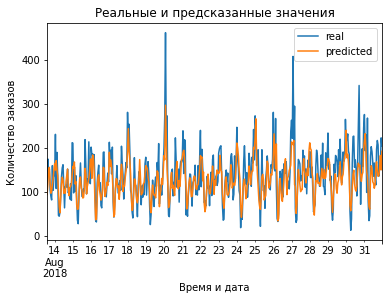

In [36]:
df_1 = pd.DataFrame()
df_1['real'] = target_test
df_1['predicted'] = predictions_cat_test
df_1.plot()
plt.title('Реальные и предсказанные значения')
plt.ylabel('Количество заказов')
plt.xlabel('Время и дата')
plt.show()

Вывод: на тестовых данных модель хорошо себя показала, RMSE в допустимом пределе, тест в сравнении с константной моделью тоже пройден.